In [1]:
import os

# Define paths
base_path = "datasets/KITTI"
splits = ["train", "val"]

for split in splits:
    img_dir = os.path.join(base_path, "images", split)
    lbl_dir = os.path.join(base_path, "labels", split)

    # Count files
    img_files = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])
    lbl_files = sorted([os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if os.path.isfile(os.path.join(lbl_dir, f))])

    print(f"\n=== {split.upper()} SPLIT ===")
    print(f"Images: {len(img_files)}")
    print(f"Labels: {len(lbl_files)}")

    # Sanity check: matching names
    missing_labels = set(img_files) - set(lbl_files)
    missing_images = set(lbl_files) - set(img_files)

    if not missing_labels and not missing_images:
        print(" All images and labels are properly paired.")
    else:
        if missing_labels:
            print(f" Missing labels for {len(missing_labels)} images.")
        if missing_images:
            print(f" Missing images for {len(missing_images)} labels.")



=== TRAIN SPLIT ===
Images: 5984
Labels: 5984
 All images and labels are properly paired.

=== VAL SPLIT ===
Images: 1497
Labels: 1497
 All images and labels are properly paired.


In [2]:
import os

# Define paths
base_path = "datasets/KITTI"
splits = ["train", "val"]

for split in splits:
    lbl_dir = os.path.join(base_path, "labels", split)

    empty_labels = []
    for f in os.listdir(lbl_dir):
        fpath = os.path.join(lbl_dir, f)
        if os.path.isfile(fpath):
            # Check if file is empty or only whitespace
            if os.stat(fpath).st_size == 0:
                empty_labels.append(f)
            else:
                with open(fpath, "r") as lf:
                    if lf.read().strip() == "":
                        empty_labels.append(f)

    print(f"\n=== {split.upper()} SPLIT ===")
    if empty_labels:
        print(f" Found {len(empty_labels)} empty label files:")
        print(empty_labels[:10], "...")  # show first 10 only
    else:
        print(" No empty label files found.")



=== TRAIN SPLIT ===
 No empty label files found.

=== VAL SPLIT ===
 No empty label files found.


In [3]:
import torch
import os

print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Torch version: 2.5.1+cu121
GPU available: True
GPU name: NVIDIA A100-SXM4-80GB


In [4]:
!pip install pycocotools numpy opencv-python tqdm tensorboard tensorboardX pyyaml webcolors matplotlib


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
# Clone repo if not already
import os, sys

if "Yet-Another-EfficientDet-Pytorch" not in os.getcwd():
    !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
    os.chdir('Yet-Another-EfficientDet-Pytorch')
    sys.path.append('.')
else:
    !git pull

# Make weights folder & download EfficientDet pretrained weights
!mkdir -p weights
!wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d5.pth -O weights/efficientdet-d5.pth


Cloning into 'Yet-Another-EfficientDet-Pytorch'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 3), reused 24 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 5.66 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (3/3), done.
--2025-08-18 09:20:23--  https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d5.pth
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/253385242/76f57900-791e-11ea-8426-1871ff7ffc4d?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-18T10%3A16%3A02Z&rscd=attachment%3B+filename%3Defficientdet-d5.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b1

In [7]:
import os
import json
from PIL import Image
from tqdm import tqdm

# === CONFIG ===
dataset_path = "/workspace/datasets/KITTI"  
splits = ["train", "val"]   # convert both
class_names = ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram"]

# === HELPER ===
def convert_yolo_to_coco(split):
    images_dir = os.path.join(dataset_path, "images", split)
    labels_dir = os.path.join(dataset_path, "labels", split)
    output_json = os.path.join(dataset_path, f"{split}.json")

    coco = {
        "info": {"description": "KITTI in COCO format"},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": []
    }

    # add categories
    for idx, name in enumerate(class_names, start=1):  # COCO category ids start at 1
        coco["categories"].append({"id": idx, "name": name})

    ann_id = 1
    img_id = 1

    for img_file in tqdm(os.listdir(images_dir)):
        if not img_file.endswith((".png", ".jpg", ".jpeg")):
            continue

        # image info
        img_path = os.path.join(images_dir, img_file)
        w, h = Image.open(img_path).size
        coco["images"].append({
            "id": img_id,
            "file_name": img_file,
            "width": w,
            "height": h
        })

        # label file
        label_file = os.path.join(labels_dir, os.path.splitext(img_file)[0] + ".txt")
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                for line in f.readlines():
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls) + 1  # shift class_id by +1 (COCO starts from 1)

                    # convert YOLO xywh (normalized) → COCO bbox [x_min, y_min, w, h]
                    x_min = (x - bw / 2) * w
                    y_min = (y - bh / 2) * h
                    box_w = bw * w
                    box_h = bh * h

                    coco["annotations"].append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": cls,
                        "bbox": [x_min, y_min, box_w, box_h],
                        "area": box_w * box_h,
                        "iscrowd": 0
                    })
                    ann_id += 1

        img_id += 1

    # save JSON
    with open(output_json, "w") as f:
        json.dump(coco, f, indent=2)
    print(f"Saved {output_json}")

# === RUN ===
for split in splits:
    convert_yolo_to_coco(split)


100%|██████████| 5984/5984 [00:05<00:00, 1022.45it/s]


Saved /workspace/datasets/KITTI/train.json


100%|██████████| 1497/1497 [00:01<00:00, 961.25it/s] 


Saved /workspace/datasets/KITTI/val.json


In [14]:
# Fix folder name case
!mv /workspace/datasets/KITTI /workspace/datasets/kitti

# Create annotation folder
!mkdir -p /workspace/datasets/kitti/annotations

# Move and rename jsons
!mv /workspace/datasets/kitti/train.json /workspace/datasets/kitti/annotations/instances_train.json
!mv /workspace/datasets/kitti/val.json /workspace/datasets/kitti/annotations/instances_val.json


In [25]:
import json
import os

# Correct lowercase path
train_json = "/workspace/datasets/kitti/annotations/instances_train.json"
val_json   = "/workspace/datasets/kitti/annotations/instances_val.json"

def verify_coco(json_path):
    print(f"\n Checking {json_path}...")
    if not os.path.exists(json_path):
        print(" File not found!")
        return
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    required_keys = ["images", "annotations", "categories"]
    for key in required_keys:
        if key not in data:
            print(f" Missing key: {key}")
            return
    
    print(f" Found {len(data['images'])} images")
    print(f" Found {len(data['annotations'])} annotations")
    print(f" Found {len(data['categories'])} categories")

    img_ids = {img["id"] for img in data["images"]}
    anno_img_ids = {anno["image_id"] for anno in data["annotations"]}
    
    missing = anno_img_ids - img_ids
    if missing:
        print(f" Some annotations reference missing images: {list(missing)[:10]}")
    else:
        print(" All annotations reference valid images")
    
    print(" File looks good!")

# Run checks
verify_coco(train_json)
verify_coco(val_json)



 Checking /workspace/datasets/kitti/annotations/instances_train.json...
 Found 5984 images
 Found 31825 annotations
 Found 7 categories
 All annotations reference valid images
 File looks good!

 Checking /workspace/datasets/kitti/annotations/instances_val.json...
 Found 1497 images
 Found 7772 annotations
 Found 7 categories
 All annotations reference valid images
 File looks good!


In [1]:
%cd /workspace/Yet-Another-EfficientDet-Pytorch


/workspace/Yet-Another-EfficientDet-Pytorch


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import cv2
import os

# Adjust paths as per your setup
train_dir = '/workspace/datasets/kitti/train'
val_dir = '/workspace/datasets/kitti/val'

def check_images(folder):
    print(f"Checking {folder}...")
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        img = cv2.imread(path)
        if img is None:
            print("Corrupted or missing:", path)

check_images(train_dir)
check_images(val_dir)


Checking /workspace/datasets/kitti/train...
Checking /workspace/datasets/kitti/val...


In [5]:
import json

train_json = '/workspace/datasets/kitti/annotations/instances_train.json'
with open(train_json) as f:
    data = json.load(f)

img_files = set(os.listdir(train_dir))
for img in data['images']:
    if img['file_name'] not in img_files:
        print("Missing in folder:", img['file_name'])


In [6]:
from efficientdet.dataset import CocoDataset
from torch.utils.data import DataLoader

dataset = CocoDataset(root_dir='/workspace/datasets/kitti', set='train')
loader = DataLoader(dataset, batch_size=1, num_workers=0)

for i, sample in enumerate(loader):
    print(sample['img'].shape, sample['annot'])
    if i==5:  # check first few samples only
        break


loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
torch.Size([1, 370, 1224, 3]) tensor([[[712.4004, 142.9998, 810.7305, 307.9199,   3.0000]]],
       dtype=torch.float64)
torch.Size([1, 375, 1242, 3]) tensor([[[599.4103, 156.4001, 629.7499, 189.2501,   2.0000],
         [387.6307, 181.5399, 423.8101, 203.1201,   0.0000],
         [676.5994, 163.9498, 688.9796, 193.9299,   5.0000]]],
       dtype=torch.float64)
torch.Size([1, 375, 1242, 3]) tensor([[[657.3894, 190.1301, 700.0694, 223.3899,   0.0000]]],
       dtype=torch.float64)
torch.Size([1, 375, 1242, 3]) tensor([[[330.0603, 178.7402, 360.7700, 238.6401,   3.0000]]],
       dtype=torch.float64)
torch.Size([1, 374, 1238, 3]) tensor([[[548.0001, 171.3301, 572.3998, 194.4202,   0.0000],
         [505.2501, 168.3699, 575.4397, 209.1801,   0.0000],
         [ 49.6995, 185.6502, 227.4194, 246.9601,   0.0000],
         [328.6704, 170.6500, 397.2408, 204.1601,   0.0000]]],
       dtype=torch.float64)
torch.S

In [8]:
!python train.py -c 5 -p kitti --head_only True --lr 1e-3 --batch_size 1 --num_epochs 2 --num_workers 0 --data_path /workspace/datasets --fast_debug


NOTE! Installing ujson may make loading annotations faster.
Loading annotations into memory...
Done (t=0.25s)
Creating index...
index created!
Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
⚡ Running in FAST DEBUG mode...
👉 Using 20 training samples and 10 validation samples
[Info] initializing weights...
[Info] freezed backbone
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:46: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Step: 19. Epoch: 0/2. Iteration: 20/20. Cls loss: 1.49781. Reg loss: 35.11673. T
Val. Epoch: 0/2. Classification loss: 1.17387. Regression loss: 5.78203. Total loss: 6.95590
Loading annotations into memory...
Done (t=0.02s)
Creating index...
index created!
Creating index...
index created!
100%|███████████████████████████████████████| 1497/1497 [04:13<00:00,  5.90it/s]
Saved eval preds to val_eval_preds.pth
Step: 39. Epoch: 1/2. Iteratio

In [11]:
!python train.py \
    -c 5 \
    -p kitti \
    --lr 1e-3 \
    --batch_size 4 \
    --num_epochs 2 \
    --num_workers 4 \
    --data_path /workspace/datasets


NOTE! Installing ujson may make loading annotations faster.
Loading annotations into memory...
Done (t=0.19s)
Creating index...
index created!
Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
[Info] initializing weights...
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:46: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Step: 1495. Epoch: 0/2. Iteration: 1496/1496. Cls loss: 0.61361. Reg loss: 5.064
Val. Epoch: 0/2. Classification loss: 0.66775. Regression loss: 4.30345. Total loss: 4.97120
Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
Creating index...
index created!
100%|███████████████████████████████████████| 1497/1497 [03:55<00:00,  6.37it/s]
Saved eval preds to val_eval_preds.pth
Loading and preparing results...
DONE (t=3.73s)
Creating index...
index created!
Running per image evaluation...
Evaluate annotation type *b

In [12]:
!python train.py \
    -c 5 \
    -p kitti \
    --lr 1e-3 \
    --batch_size 4 \
    --num_epochs 200 \
    --num_workers 4 \
    --data_path /workspace/datasets \
    --val_interval 1 \
    --save_interval 20 \
    --es_patience 10 \
    --es_min_delta 0.001


NOTE! Installing ujson may make loading annotations faster.
Loading annotations into memory...
Done (t=0.19s)
Creating index...
index created!
Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
[Info] initializing weights...
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:46: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Step: 1495. Epoch: 0/200. Iteration: 1496/1496. Cls loss: 0.55568. Reg loss: 4.2
Val. Epoch: 0/200. Classification loss: 0.62496. Regression loss: 4.07151. Total loss: 4.69647
Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
Creating index...
index created!
100%|███████████████████████████████████████| 1497/1497 [03:52<00:00,  6.45it/s]
Saved eval preds to val_eval_preds.pth
Loading and preparing results...
DONE (t=4.38s)
Creating index...
index created!
Running per image evaluation...
Evaluate annotation type 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step: 89759. Epoch: 59/200. Iteration: 1496/1496. Cls loss: 0.02254. Reg loss: 0
Val. Epoch: 59/200. Classification loss: 0.09116. Regression loss: 0.56189. Total loss: 0.65305
Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
Creating index...
index created!
100%|███████████████████████████████████████| 1497/1497 [03:43<00:00,  6.69it/s]
Saved eval preds to val_eval_preds.pth
Loading and preparing results...
DONE (t=0.10s)
Creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.86s).
Accumulating evaluation results...
DONE (t=0.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.58115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.81222
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.65355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.58115
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [15]:
# Go to the folder where KITTI checkpoints are saved
%cd logs/kitti

# List all EfficientDet weight files, sorted by date
weight_file = !ls -Art | grep efficientdet

# Check latest checkpoint
print("Latest checkpoint:", weight_file[-1])

# Go back to project root
%cd ../..


/workspace/Yet-Another-EfficientDet-Pytorch/logs/kitti


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Latest checkpoint: efficientdet-d5_best.pth
/workspace/Yet-Another-EfficientDet-Pytorch


In [4]:
!python coco_eval.py -c 5 -p kitti -w "logs/kitti/{weight_file[-1]}"


NOTE! Installing ujson may make loading annotations faster.
^C
Traceback (most recent call last):
  File "/workspace/Yet-Another-EfficientDet-Pytorch/coco_eval.py", line 23, in <module>
    from backbone import EfficientDetBackbone
  File "/workspace/Yet-Another-EfficientDet-Pytorch/backbone.py", line 6, in <module>
    from efficientdet.model import BiFPN, Regressor, Classifier, EfficientNet
  File "/workspace/Yet-Another-EfficientDet-Pytorch/efficientdet/model.py", line 3, in <module>
    from torchvision.ops.boxes import nms as nms_torch
  File "/usr/local/lib/python3.10/dist-packages/torchvision/__init__.py", line 6, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/convnext.py", line 8, in <module>
    from ..ops.misc import Conv2dNo

In [1]:
cd Yet-Another-EfficientDet-Pytorch

/workspace/Yet-Another-EfficientDet-Pytorch


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [24]:
import os
print(os.getcwd())


/workspace/Yet-Another-EfficientDet-Pytorch


In [34]:
import json

val_json = "/workspace/datasets/kitti/annotations/instances_val.json"

with open(val_json, "r") as f:
    data = json.load(f)

cats = data["categories"]
print("Categories in JSON:")
for c in cats:
    print(c["id"], c["name"])

print("\nNum classes in JSON:", len(cats))
print("Num classes in YAML (obj_list):", 7)


Categories in JSON:
1 Car
2 Van
3 Truck
4 Pedestrian
5 Person_sitting
6 Cyclist
7 Tram

Num classes in JSON: 7
Num classes in YAML (obj_list): 7


In [55]:
import torch

ckpt = torch.load("logs/kitti/efficientdet-d5_best.pth", map_location="cpu")

# if checkpoint is just a state_dict
if isinstance(ckpt, dict) and "model" not in ckpt:
    state_dict = ckpt
else:
    state_dict = ckpt["model"]

# find class-related layers
for k, v in state_dict.items():
    if "class" in k.lower() or "cls" in k.lower():
        print(k, v.shape)


classifier.conv_list.0.depthwise_conv.conv.weight torch.Size([288, 1, 3, 3])
classifier.conv_list.0.pointwise_conv.conv.weight torch.Size([288, 288, 1, 1])
classifier.conv_list.0.pointwise_conv.conv.bias torch.Size([288])
classifier.conv_list.1.depthwise_conv.conv.weight torch.Size([288, 1, 3, 3])
classifier.conv_list.1.pointwise_conv.conv.weight torch.Size([288, 288, 1, 1])
classifier.conv_list.1.pointwise_conv.conv.bias torch.Size([288])
classifier.conv_list.2.depthwise_conv.conv.weight torch.Size([288, 1, 3, 3])
classifier.conv_list.2.pointwise_conv.conv.weight torch.Size([288, 288, 1, 1])
classifier.conv_list.2.pointwise_conv.conv.bias torch.Size([288])
classifier.conv_list.3.depthwise_conv.conv.weight torch.Size([288, 1, 3, 3])
classifier.conv_list.3.pointwise_conv.conv.weight torch.Size([288, 288, 1, 1])
classifier.conv_list.3.pointwise_conv.conv.bias torch.Size([288])
classifier.bn_list.0.0.weight torch.Size([288])
classifier.bn_list.0.0.bias torch.Size([288])
classifier.bn_list

/tmp/ipykernel_411432/2939981844.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("logs/kitti/efficientdet-d5_1_374.pth", map_location="cpu")


In [68]:
import os

img_path = "/workspace/datasets/kitti/val/007473.png"
print("Exists?", os.path.exists(img_path))


Exists? True


In [69]:
from utils.utils import preprocess
import cv2
import numpy as np

img_file = "/workspace/datasets/kitti/val/007473.png"
img = cv2.imread(img_file)
print("CV2 read:", img is not None, img.shape if img is not None else None)

ori_imgs, framed_imgs, framed_metas = preprocess(
    img_file,
    max_size=1280,   # or input_sizes[compound_coef]
    mean=[0.485,0.456,0.406],
    std=[0.229,0.224,0.225]
)
print("Preprocess output:", ori_imgs, framed_imgs, framed_metas)


CV2 read: True (370, 1224, 3)
Preprocess output: [array([[[17, 26, 21],
        [20, 27, 22],
        [22, 25, 22],
        ...,
        [69, 70, 50],
        [62, 65, 45],
        [43, 62, 46]],

       [[19, 25, 17],
        [19, 27, 17],
        [20, 26, 17],
        ...,
        [48, 62, 44],
        [38, 52, 49],
        [27, 43, 48]],

       [[19, 33, 36],
        [19, 33, 38],
        [19, 31, 32],
        ...,
        [11, 36, 37],
        [15, 28, 36],
        [19, 31, 33]],

       ...,

       [[55, 47, 36],
        [59, 46, 35],
        [59, 45, 35],
        ...,
        [46, 49, 62],
        [47, 52, 69],
        [50, 58, 68]],

       [[57, 47, 33],
        [60, 47, 33],
        [59, 47, 32],
        ...,
        [46, 50, 67],
        [47, 52, 68],
        [48, 53, 70]],

       [[60, 48, 34],
        [60, 48, 34],
        [60, 47, 35],
        ...,
        [44, 59, 66],
        [42, 52, 68],
        [39, 49, 70]]], dtype=uint8)] [array([[[-1.7582841 , -1.5805322 , -1.50

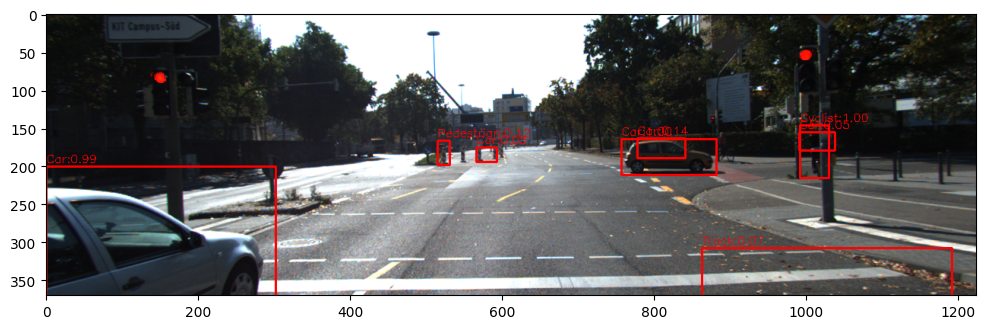

In [13]:
import torch
import cv2
import matplotlib.pyplot as plt
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, postprocess, invert_affine

# ==== Settings ====
compound_coef = 5
weights_path = "logs/kitti/efficientdet-d5_best.pth"  # change to your latest checkpoint
image_path = "/workspace/datasets/kitti/val/007473.png"
use_cuda = True
gpu = 0
threshold = 0.05
nms_threshold = 0.5

# ==== Load model ====
params = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'anchors_ratios': '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]',
    'anchors_scales': '[2 ** 0, 2 ** (1.0/3.0), 2 ** (2.0/3.0)]'
}
obj_list = ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram"]

model = EfficientDetBackbone(compound_coef=compound_coef,
                             num_classes=len(obj_list),
                             ratios=eval(params['anchors_ratios']),
                             scales=eval(params['anchors_scales']))
model.load_state_dict(torch.load(weights_path, map_location='cpu'))
model.requires_grad_(False)
model.eval()
if use_cuda:
    model.cuda(gpu)

# ==== Preprocess image ====
ori_imgs, framed_imgs, framed_metas = preprocess(image_path, max_size=1280,
                                                  mean=params['mean'], std=params['std'])
x = torch.from_numpy(framed_imgs[0]).unsqueeze(0).permute(0, 3, 1, 2).float()
if use_cuda:
    x = x.cuda(gpu)

# ==== Run inference ====
regressBoxes = BBoxTransform()
clipBoxes = ClipBoxes()
with torch.no_grad():
    features, regression, classification, anchors = model(x)
    preds = postprocess(x, anchors, regression, classification,
                        regressBoxes, clipBoxes, threshold, nms_threshold)
preds = invert_affine(framed_metas, preds)[0]

# ==== Visualize ====
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box, cls, score in zip(preds['rois'], preds['class_ids'], preds['scores']):
    if score < 0.05:
        continue
    x1, y1, x2, y2 = box
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
    cv2.putText(img, f"{obj_list[int(cls)]}:{score:.2f}", (int(x1), int(y1)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

plt.figure(figsize=(12,6))
plt.imshow(img)
plt.show()


In [13]:
!python /workspace/compute_metrics.py \
  --gt /workspace/datasets/kitti/annotations/instances_val.json \
  --pred val_bbox_results.json \
  --yaml projects/kitti.yml \
  --weights logs/kitti/efficientdet-d5_best.pth \
  --compound 5 \
  --images /workspace/datasets/kitti/val \
  --out metrics_kitti_d5


/workspace/compute_metrics.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  preds = torch.load("preds.pt")   # list of dicts [{boxes, labels, scores}, ...]
Traceback (mo

In [10]:
pip install xlsxwriter openpyxl


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [openpyxl]2/3 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 423.8 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
import torch
import numpy as np
from pycocotools.coco import COCO

# ------------------ SETTINGS ------------------
val_set = "val"  # KITTI val folder name
VAL_GT = "/workspace/datasets/kitti/annotations/instances_val.json"
VAL_IMGS = "/workspace/datasets/kitti/val"
MAX_IMAGES = 10000
categories = ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram"]
num_classes = len(categories)

# ------------------ LOAD GT ------------------
coco_gt = COCO(VAL_GT)

# Adjust category IDs if necessary (KITTI COCO mapping)
for ann in coco_gt.dataset['annotations']:
    ann['category_id'] -= 1
for cat in coco_gt.dataset['categories']:
    cat['id'] -= 1
coco_gt.createIndex()
image_ids = coco_gt.getImgIds()[:MAX_IMAGES]

# ------------------ LOAD PREDICTIONS ------------------
#all_preds = torch.load(f"{val_set}_eval_preds.pth")  # dict: image_id -> {'boxes':..., 'scores':..., 'labels':...}
data = torch.load(f"{val_set}_eval_preds.pth")
all_preds = data['preds']        # list of predictions per image
all_targets = data['targets']    # list of ground truths per image (optional if needed)

# ------------------ INITIALIZE METRICS ------------------
TP = np.zeros(num_classes)
FP = np.zeros(num_classes)
FN = np.zeros(num_classes)
TN = np.zeros(num_classes)

# For precision/recall plotting
all_confidences = [[] for _ in range(num_classes)]
all_matches = [[] for _ in range(num_classes)]

# ------------------ COMPUTE METRICS ------------------
for img_id in image_ids:
    gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
    #pred = all_preds[img_id] if img_id in all_preds else {'boxes': np.array([]), 'scores': np.array([]), 'labels': np.array([])}
    # index i corresponds to the order in val_generator / all_preds
    pred = all_preds[i] if i < len(all_preds) else {'boxes': np.array([]), 'scores': np.array([]), 'labels': np.array([])}
    
    # GT boxes and labels
    gt_boxes = np.array([ann['bbox'] for ann in gt_anns])
    if len(gt_boxes) > 0:
        gt_boxes[:,2:] += gt_boxes[:,:2]  # convert [x,y,w,h] -> [x1,y1,x2,y2]
        gt_labels = np.array([categories.index(coco_gt.loadCats([ann['category_id']])[0]['name']) for ann in gt_anns])
    else:
        gt_labels = np.array([])

    # Predictions
    pred_boxes = pred['rois']
    pred_labels = pred['class_ids']
    pred_scores = pred['scores']

    # Initialize detection flags
    detected_gt = np.zeros(len(gt_labels), dtype=bool)

    # Compute TP, FP per prediction
    for i in range(len(pred_boxes)):
        p_box = pred_boxes[i]
        p_label = pred_labels[i]
        p_score = pred_scores[i]

        if len(gt_boxes) == 0:
            FP[p_label] += 1
            all_confidences[p_label].append(p_score)
            all_matches[p_label].append(0)
            continue

        # IoU with all GT of same class
        ious = []
        for j, g_label in enumerate(gt_labels):
            if g_label != p_label or detected_gt[j]:
                ious.append(0)
                continue
            g_box = gt_boxes[j]
            xx1 = max(p_box[0], g_box[0])
            yy1 = max(p_box[1], g_box[1])
            xx2 = min(p_box[2], g_box[2])
            yy2 = min(p_box[3], g_box[3])
            w = max(0, xx2 - xx1)
            h = max(0, yy2 - yy1)
            iou = w*h / ((p_box[2]-p_box[0])*(p_box[3]-p_box[1]) + (g_box[2]-g_box[0])*(g_box[3]-g_box[1]) - w*h)
            ious.append(iou)
        
        max_iou_idx = np.argmax(ious)
        if ious[max_iou_idx] >= 0.5:
            TP[p_label] += 1
            detected_gt[max_iou_idx] = True
            all_confidences[p_label].append(p_score)
            all_matches[p_label].append(1)
        else:
            FP[p_label] += 1
            all_confidences[p_label].append(p_score)
            all_matches[p_label].append(0)

    # FN for missed GTs
    for j, g_label in enumerate(gt_labels):
        if not detected_gt[j]:
            FN[g_label] += 1

# ------------------ CALCULATE METRICS ------------------
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2*precision*recall / (precision + recall + 1e-8)
accuracy = TP / (TP + FP + FN + 1e-8)

# Overall
overall_precision = TP.sum() / (TP.sum() + FP.sum() + 1e-8)
overall_recall = TP.sum() / (TP.sum() + FN.sum() + 1e-8)
overall_f1 = 2*overall_precision*overall_recall / (overall_precision + overall_recall + 1e-8)

# ------------------ PRINT ------------------
for i, cls_name in enumerate(categories):
    print(f"{cls_name}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}, Accuracy={accuracy[i]:.4f}")

print(f"\nOverall: Precision={overall_precision:.4f}, Recall={overall_recall:.4f}, F1={overall_f1:.4f}, , Accuracy={overall_accuracy:.4f}")

# ------------------ SAVE TO CSV ------------------
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Class", "TP", "FP", "FN", "Precision", "Recall", "F1", "Accuracy"])
    for i, cls_name in enumerate(categories):
        writer.writerow([cls_name, int(TP[i]), int(FP[i]), int(FN[i]),
                         precision[i], recall[i], f1[i], accuracy[i]])
    writer.writerow(["Overall", int(TP.sum()), int(FP.sum()), int(FN.sum()),
                     overall_precision, overall_recall, overall_f1, overall_accuracy])
print(f"Metrics saved to {csv_file}")

In [20]:
import json

with open("val_bbox_results.json") as f:
    data = json.load(f)

print(type(data))
print(len(data))
print(data[0])


<class 'list'>
24311
{'image_id': 1, 'category_id': 1, 'score': 0.9956763386726379, 'bbox': [614.7482299804688, 182.37210083007812, 112.6488037109375, 102.232666015625]}


In [25]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Paths
gt_path = "/workspace/datasets/kitti/annotations/instances_val.json"  # Ground truth
pred_path = "val_bbox_results.json"  # Predictions

# Load COCO ground truth and predictions
coco_gt = COCO(gt_path)
coco_dt = coco_gt.loadRes(pred_path)

# COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading annotations into memory...
Done (t=0.02s)
Creating index...
index created!
Loading and preparing results...
DONE (t=0.25s)
Creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.67s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.53822
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.75995
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.60288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.55840
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.58542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.52033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.39853
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.61643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

In [31]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# === Paths ===
ann_file = '/workspace/datasets/kitti/annotations/instances_val.json'
pred_file = 'val_bbox_results.json'

# === Load data ===
coco_gt = COCO(ann_file)
coco_dt = coco_gt.loadRes(pred_file)

# Category info
cat_ids = coco_gt.getCatIds()
cats = coco_gt.loadCats(cat_ids)
class_names = [c['name'] for c in cats]

# Manual TP, FP, FN computation
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

iou_threshold = 0.5

for img_id in coco_gt.getImgIds():
    gt_ids = coco_gt.getAnnIds(imgIds=img_id)
    dt_ids = coco_dt.getAnnIds(imgIds=img_id)

    gt_anns = coco_gt.loadAnns(gt_ids)
    dt_anns = coco_dt.loadAnns(dt_ids)

    matched_gt = set()
    for dt in sorted(dt_anns, key=lambda x: -x['score']):
        best_iou = 0
        best_gt = None
        for gt in gt_anns:
            if gt['category_id'] == dt['category_id'] and gt['id'] not in matched_gt:
                # IoU calculation
                x1 = max(gt['bbox'][0], dt['bbox'][0])
                y1 = max(gt['bbox'][1], dt['bbox'][1])
                x2 = min(gt['bbox'][0] + gt['bbox'][2], dt['bbox'][0] + dt['bbox'][2])
                y2 = min(gt['bbox'][1] + gt['bbox'][3], dt['bbox'][1] + dt['bbox'][3])
                inter = max(0, x2 - x1) * max(0, y2 - y1)
                gt_area = gt['bbox'][2] * gt['bbox'][3]
                dt_area = dt['bbox'][2] * dt['bbox'][3]
                union = gt_area + dt_area - inter
                iou = inter / union if union > 0 else 0
                if iou > best_iou:
                    best_iou = iou
                    best_gt = gt
        if best_iou >= iou_threshold:
            tp[class_names[dt['category_id']-1]] += 1
            matched_gt.add(best_gt['id'])
        else:
            fp[class_names[dt['category_id']-1]] += 1

    for gt in gt_anns:
        if gt['id'] not in matched_gt:
            fn[class_names[gt['category_id']-1]] += 1

# Compute per-class metrics
metrics = []
for cls in class_names:
    TP = tp[cls]
    FP = fp[cls]
    FN = fn[cls]
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    fpr = FP / (FP + TP) if FP + TP > 0 else 0
    fnr = FN / (FN + TP) if FN + TP > 0 else 0
    metrics.append([cls, TP, FP, FN, precision, recall, f1, fpr, fnr])

# === Compute Overall Metrics ===
total_TP = sum(tp.values())
total_FP = sum(fp.values())
total_FN = sum(fn.values())

overall_precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
overall_recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
overall_fpr = total_FP / (total_FP + total_TP) if total_FP + total_TP > 0 else 0
overall_fnr = total_FN / (total_FN + total_TP) if total_FN + total_TP > 0 else 0

metrics.append(["Overall", total_TP, total_FP, total_FN, overall_precision, overall_recall, overall_f1, overall_fpr, overall_fnr])

# Save to CSV
df = pd.DataFrame(metrics, columns=['Class', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'FPR', 'FNR'])
df.to_csv('efficient_detd5_metrics.csv', index=False)
print("Metrics saved to efficient_detd5_metrics.csv")


Loading annotations into memory...
Done (t=0.02s)
Creating index...
index created!
Loading and preparing results...
DONE (t=0.39s)
Creating index...
index created!
Metrics saved to efficient_detd5_metrics.csv


In [30]:
from pycocotools.cocoeval import COCOeval
import numpy as np
import pandas as pd

# === Paths ===
gt_path = "/workspace/datasets/kitti/annotations/instances_val.json"
pred_path = "val_bbox_results.json"

# === Load COCO ground truth and predictions ===
coco_gt = COCO(gt_path)
coco_dt = coco_gt.loadRes(pred_path)

# === Initialize COCOeval ===
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# === Extract category-wise AP ===
cat_ids = coco_gt.getCatIds()
cat_names = [coco_gt.loadCats([cid])[0]["name"] for cid in cat_ids]

# Create DataFrame for storing metrics
metrics = []

for i, cid in enumerate(cat_ids):
    # For each category
    precision = coco_eval.eval['precision']  # shape: [TxRxKxAxM]
    # For IoU thresholds
    iou50_idx = np.where(np.isclose(coco_eval.params.iouThrs, 0.5))[0][0]
    
    # AP@[.50:.95]
    ap_50_95 = np.mean(precision[:, :, i, 0, -1][precision[:, :, i, 0, -1] > -1])
    # AP@.50
    ap_50 = np.mean(precision[iou50_idx, :, i, 0, -1][precision[iou50_idx, :, i, 0, -1] > -1])
    
    metrics.append({
        "Class": cat_names[i],
        "mAP@0.5": round(ap_50 * 100, 2),
        "mAP@0.5:0.95": round(ap_50_95 * 100, 2)
    })

# === Overall row ===
overall_ap50 = coco_eval.stats[1] * 100      # AP@0.5
overall_ap5095 = coco_eval.stats[0] * 100    # AP@[.50:.95]

metrics.append({
    "Class": "Overall",
    "mAP@0.5": round(overall_ap50, 2),
    "mAP@0.5:0.95": round(overall_ap5095, 2)
})

# Convert to DataFrame and save
df = pd.DataFrame(metrics)
print(df)

df.to_csv("KITTI_mAP_per_class.csv", index=False)
print("Saved metrics to KITTI_mAP_per_class.csv")


Loading annotations into memory...
Done (t=0.03s)
Creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
Creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.89s).
Accumulating evaluation results...
DONE (t=0.43s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.53822
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.75995
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.60288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.55840
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.58542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.52033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.39853
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.61643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

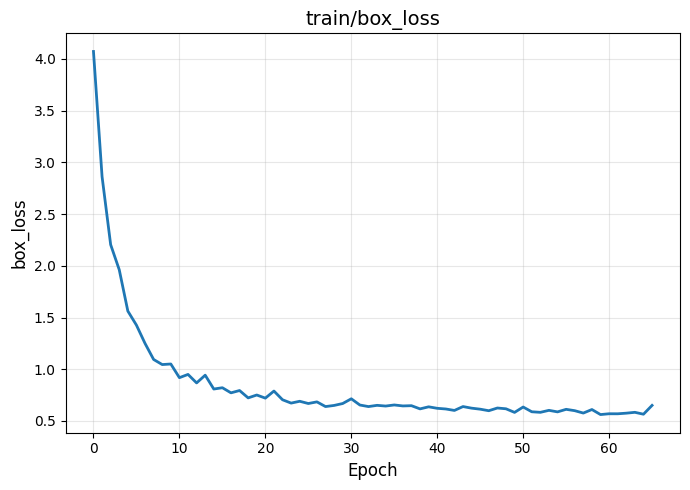

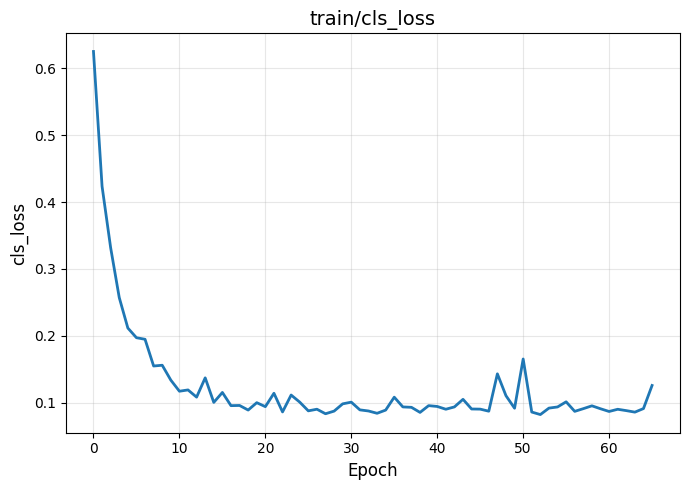

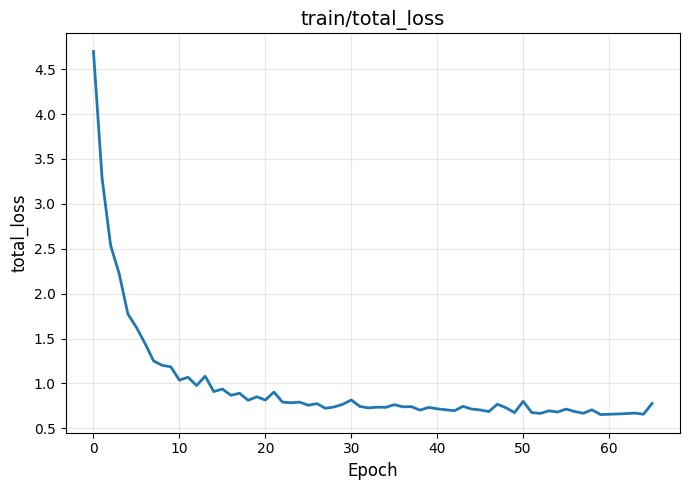

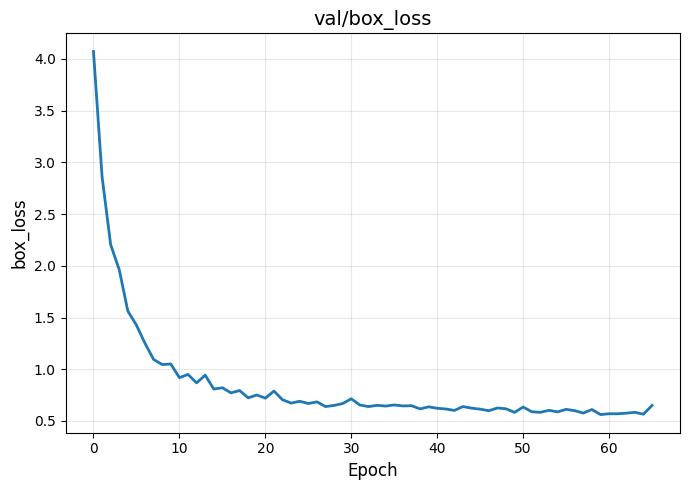

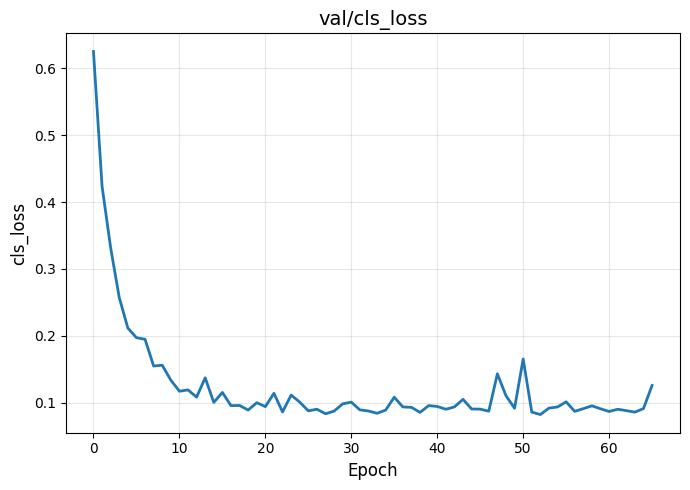

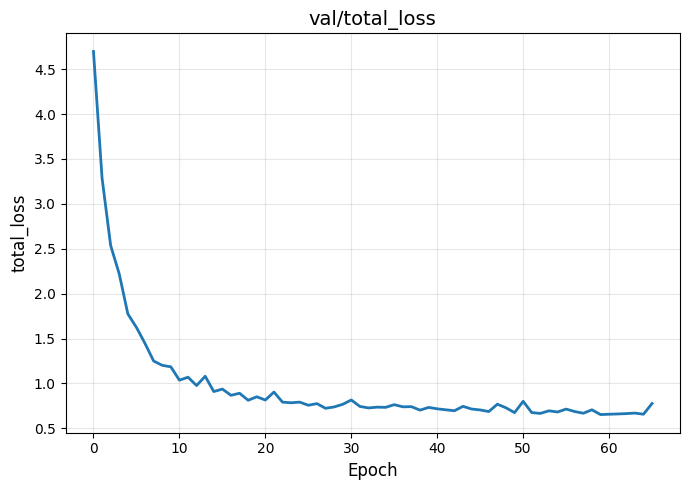

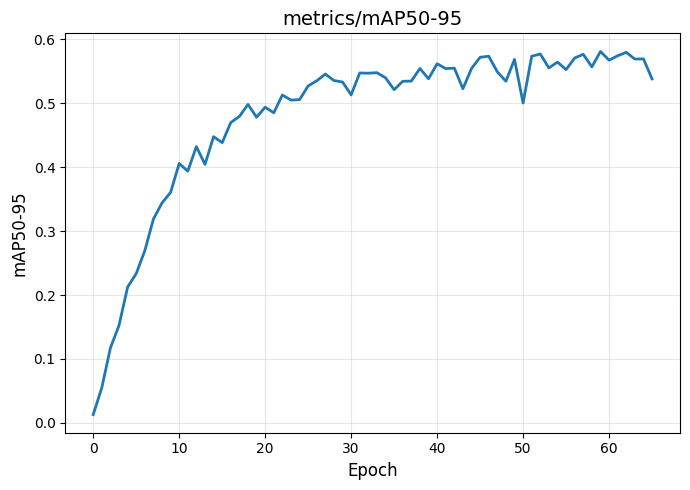

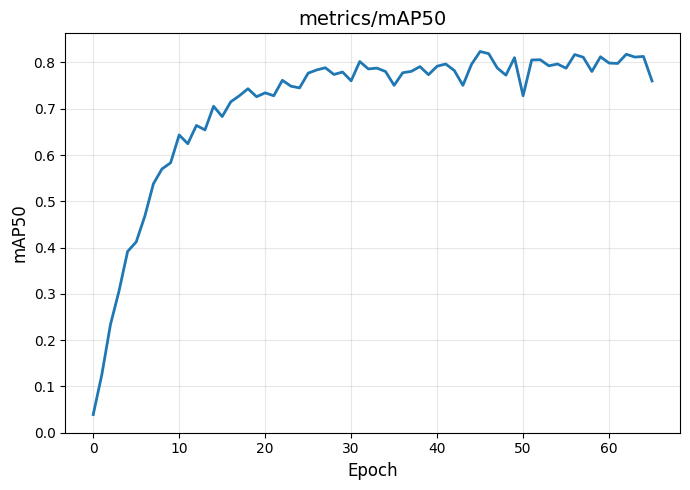

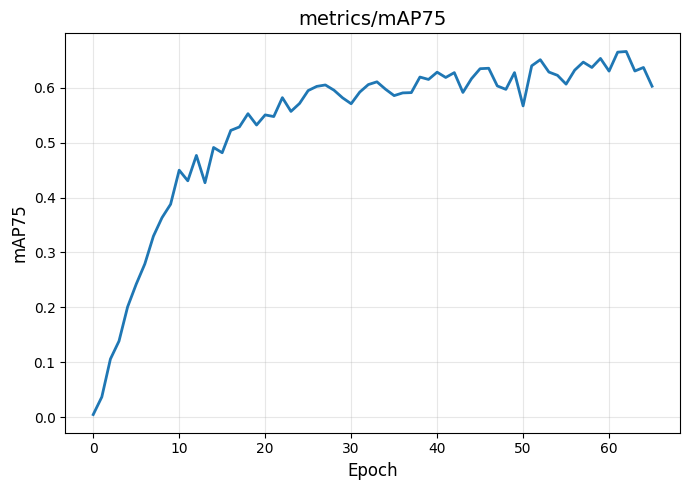

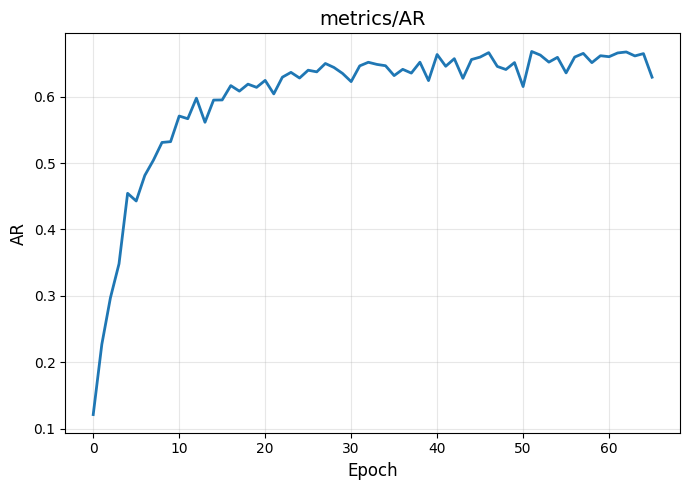

 All plots saved in 'plots/'


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('logs/kitti/metrics.csv')
epochs = df['epoch']

# List of metrics to plot
metrics = [
    'train/box_loss', 'train/cls_loss', 'train/total_loss',
    'val/box_loss', 'val/cls_loss', 'val/total_loss',
    'metrics/mAP50-95', 'metrics/mAP50', 'metrics/mAP75',
    'metrics/AR'
]

# Create output folder
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# YOLO-style color
color = '#1f77b4'

# Generate plots
for metric in metrics:
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, df[metric], color=color, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.split('/')[-1], fontsize=12)
    plt.title(metric, fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save plot
    filename = f"{metric.replace('/', '_')}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    plt.show()

print(f" All plots saved in '{output_dir}/'")


In [47]:
# ========================
# PLOTS WITH BEST POINT ANNOTATIONS (YOLO style)
# ========================
def plot_curve(metric_dict, overall, ylabel, filename):
    plt.figure(figsize=(8,6))
    for cls in CLASSES:
        plt.plot(conf_thresholds, metric_dict[cls], label=cls)
    
    # Find best point on overall line
    best_idx = np.argmax(overall)
    best_val = overall[best_idx]
    best_conf = conf_thresholds[best_idx]
    overall_label = f"All classes {best_val:.3f} at {best_conf:.3f}"
    
    plt.plot(conf_thresholds, overall, label=overall_label, linewidth=2, color='black', linestyle='--')
    plt.scatter(best_conf, best_val, color='red')  # mark best point
    
    plt.xlabel('Confidence')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} vs Confidence')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # fixed legend on right
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, filename), dpi=300)
    plt.close()

# Precision vs Confidence
plot_curve(precision_per_class, overall_precision, 'Precision', 'P_curve.png')

# Recall vs Confidence
plot_curve(recall_per_class, overall_recall, 'Recall', 'R_curve.png')

# F1 vs Confidence
plot_curve(f1_per_class, overall_f1_list, 'F1-score', 'F1_curve.png')

# Precision-Recall curve (overall and classes)
plt.figure(figsize=(8,6))
for cls in CLASSES:
    plt.plot(recall_per_class[cls], precision_per_class[cls], label=cls)

# Overall line with best F1 annotation
best_idx = np.argmax(overall_f1_list)
best_f1 = overall_f1_list[best_idx]
best_rec = overall_recall[best_idx]
best_prec = overall_precision[best_idx]
overall_label = f"All classes {best_f1:.3f} at {conf_thresholds[best_idx]:.3f}"

plt.plot(overall_recall, overall_precision, label=overall_label, linewidth=2, color='black', linestyle='--')
plt.scatter(best_rec, best_prec, color='red')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'PR_curve.png'), dpi=300)
plt.close()

print(f"All curves saved in: {save_dir}")


All curves saved in: runs/plots


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ========================
# CONFIG
# ========================
save_dir = "runs/plots"
os.makedirs(save_dir, exist_ok=True)

# Load metrics CSV generated previously
metrics_csv = "efficient_detd5_metrics.csv"  # change if needed
df = pd.read_csv(metrics_csv)

# Classes and add background
CLASSES = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']
CLASSES_BG = CLASSES + ['Background']
num_classes_bg = len(CLASSES_BG)
class_to_idx_bg = {cls: i for i, cls in enumerate(CLASSES_BG)}

# ========================
# BUILD CONFUSION MATRIX
# ========================
cm_raw_bg = np.zeros((num_classes_bg, num_classes_bg), dtype=int)

# Fill TP (diagonal), FN (row -> Background), FP (column -> Background)
for _, row in df[df['Class'] != 'Overall'].iterrows():
    cls_name = row['Class']
    idx = class_to_idx_bg[cls_name]
    TP = int(row['TP'])
    FP = int(row['FP'])
    FN = int(row['FN'])

    # True Positive
    cm_raw_bg[idx, idx] = TP

    # False Negative → GT exists, but prediction missed
    cm_raw_bg[idx, class_to_idx_bg['Background']] = FN

    # False Positive → prediction exists, but no GT match
    cm_raw_bg[class_to_idx_bg['Background'], idx] = FP

# Normalized confusion matrix (rows sum to 1)
cm_norm_bg = cm_raw_bg.astype(float)
row_sums = cm_norm_bg.sum(axis=1, keepdims=True)
cm_norm_bg = cm_norm_bg / np.clip(row_sums, 1, None)

# Save CSVs
pd.DataFrame(cm_raw_bg, index=CLASSES_BG, columns=CLASSES_BG).to_csv(os.path.join(save_dir, "conf_matrix_raw_bg.csv"))
pd.DataFrame(cm_norm_bg, index=CLASSES_BG, columns=CLASSES_BG).to_csv(os.path.join(save_dir, "conf_matrix_normalized_bg.csv"))

# ========================
# PLOT FUNCTION
# ========================
def plot_conf_matrix(cm, classes, title, filename, normalize=False):
    plt.figure(figsize=(10,8))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.tight_layout()
    plt.grid(False)
    plt.savefig(os.path.join(save_dir, filename), dpi=300)
    plt.close()

# Plot raw confusion matrix
plot_conf_matrix(cm_raw_bg, CLASSES_BG, "Confusion Matrix (Raw counts)", "conf_matrix_raw_bg.png", normalize=False)

# Plot normalized confusion matrix
plot_conf_matrix(cm_norm_bg, CLASSES_BG, "Confusion Matrix (Normalized)", "conf_matrix_normalized_bg.png", normalize=True)

print(f"Confusion matrices saved in: {save_dir}")


Confusion matrices saved in: runs/plots


In [53]:
!pip install effdet


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 654.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.0/455.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=eed3932

In [57]:
import torch
import torch.nn as nn
from effdet import create_model
import time
import os

# ========================
# CONFIG
# ========================
model_name = 'efficientdet_d5'
num_classes = 7  # KITTI classes
image_size = 1280  # 1280x1280
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'logs/kitti/efficientdet-d5_best.pth'

# ========================
# CREATE MODEL (IGNORE WEIGHTS)
# ========================
model = create_model(
    model_name,
    num_classes=num_classes,
    pretrained=False
)
model.eval().to(device)

# ========================
# MODEL SIZE
# ========================
# If best.pth exists, get its file size
if os.path.exists(model_path):
    size_mb = os.path.getsize(model_path) / (1024**2)
else:
    size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)  # fallback
print(f"Model file size: {size_mb:.2f} MB")

# ========================
# MODEL PARAMETERS
# ========================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# ========================
# INFERENCE FPS
# ========================
dummy_input = torch.randn(1, 3, image_size, image_size).to(device)

# Warm-up
for _ in range(10):
    with torch.no_grad():
        _ = model(dummy_input)

# Timing
n_runs = 50
torch.cuda.synchronize() if device=='cuda' else None
start = time.time()
for _ in range(n_runs):
    with torch.no_grad():
        _ = model(dummy_input)
torch.cuda.synchronize() if device=='cuda' else None
end = time.time()

fps = n_runs / (end - start)
print(f"Inference FPS (@{image_size}x{image_size}): {fps:.2f}")


Model file size: 129.02 MB
Total parameters: 33,437,432
Trainable parameters: 33,437,432
Inference FPS (@1280x1280): 22.19


In [59]:
import shutil

# Paths
folder_path = '/workspace/Yet-Another-EfficientDet-Pytorch'  # Change to your folder path
zip_path = '/workspace/Yet-Another-EfficientDet-Pytorch.zip'  # Output zip file

# Create zip
shutil.make_archive(base_name=zip_path.replace('.zip',''), format='zip', root_dir=folder_path)

print(f"Folder zipped at: {zip_path}")

# For Colab: download
files.download(zip_path)


Folder zipped at: /workspace/Yet-Another-EfficientDet-Pytorch.zip


NameError: name 'files' is not defined